In [1]:
import os
from os.path import join, isfile
from typing import List, Dict, Any

import sys
sys.path.insert(0,'..')
from src.test_data import TEST_EXAMPLES
from src.env import Env
from src.helpers import LANGUAGES


from ipywidgets import interact, Checkbox

from plots import get_models_in_output_dir
from plots import tokenize_hf
from plots import tokenize_sp
from plots import display
from plots import decode_hack

from plots import get_models_multilinguality
from plots import get_intersection
from plots import get_intersections

from plots import plot_histogram, compare_vocab, plot_overview, plot_timelines, plot_overview_data, plot_vocab_size

from plots import get_list_of_results
from plots import read_results
from plots import retrieve_groups_from_results
from plots import retrieve_parameters_from_results
from plots import color as plots_color
from plots import extract

from analysis import analyze_vocab

import numpy as np
import seaborn as sns
from itertools import product

None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


In [2]:
env = Env("..")
for k, v in env.__dict__.items():
    print(f"{k.ljust(13)}: {v}")
OUTPUT_DIR = env.output

data_original: /Users/felixstollenwerk/Repos/gpt-sw3-tokenizer/data_original
data_train   : /Users/felixstollenwerk/Repos/gpt-sw3-tokenizer/data_train_0.01p_EN_PLUS
data_eval    : /Users/felixstollenwerk/Repos/gpt-sw3-tokenizer/data_eval_0.01p_EN_PLUS
output       : /Users/felixstollenwerk/Repos/gpt-sw3-tokenizer/output_0.01p_EN_PLUS
debug        : False
verbose      : False


In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

# 0. Models

In [4]:
models = get_models_in_output_dir()
models

['152808_SP-uNone-d1-p1-w2-c1-f0-bf1-cc0.9999-x1-v64000_tokenizer1',
 '152836_SP-uNone-d1-p1-w2-c1-f0-bf1-cc0.9999-x1-v64000_tokenizer1_en']

In [5]:
# STOP

# 1. Tokenization examples

In [6]:
def show_example_model(example: str, 
                       model: str, 
                       show_tokenization: bool = True, 
                       verbose: bool = False):
    
    _id = model.split("_")[0]
    
    if isfile(join(OUTPUT_DIR, model, "tokenizer.json")):
        texample = tokenize_hf(model, example)
    elif isfile(join(OUTPUT_DIR, model, "model.model")):
        texample = tokenize_sp(model, example)
    else:
        raise Exception(f"ERROR! could not find tokenizer for model = {model}.")
    # assert "".join(texample['de-tokenized_elementwise']) == texample['de-tokenized'], f"ERROR de-tokenized elementwise!"
    
    print(f"\n============ {model}")
    print("\noriginal:")
    print(example)
    # print(f"example: '{example}'")
    # print(f"\nencoded: {texample['encoded']}")
    # print(f"\ntokenized: {texample['tokenized']} --- {len(texample['tokenized'])}")
    # print(f"\nde-tokenized: '{texample['de-tokenized']}'")
    # print(f"\nde-tokenized elementwise: {texample['de-tokenized_elementwise']}")
    
    if show_tokenization: 
        print("\ntokenized:")
        display(texample['tokenized'], verbose=verbose)
        print("de-tokenized:")
        display(texample['de-tokenized_elementwise'], 
                show_linebreak=True, 
                equal_to_original=example == texample['de-tokenized'],
                verbose=verbose)
        if 'de-tokenized_elementwise_hack' in texample.keys():
            print("\ndecoded + hack:")
            display(texample['de-tokenized_elementwise_hack'], show_linebreak=True, verbose=verbose)

In [7]:
@interact
def show_examples(example=TEST_EXAMPLES, 
                  model=models, 
                  show_tokenization=True, 
                  verbose=False):
    show_example_model(example, model, show_tokenization, verbose)

interactive(children=(Dropdown(description='example', options=('<|python|> def fibRec(n):\n    if n < 2:\n    …

In [8]:
# STOP

# 2. Vocabulary

### 2a. Subword Length Histograms

In [9]:
@interact
def show_histogram(model_1=models, model_2=[None] + models, xlim=20, ylim=15000):
    plot_histogram(model_1, model_2, xlim, ylim)

interactive(children=(Dropdown(description='model_1', options=('152808_SP-uNone-d1-p1-w2-c1-f0-bf1-cc0.9999-x1…

In [10]:
# STOP

### 2b. Overlap

In [11]:
@interact
def show_compare_vocab(model_1=models, model_2=models, nr=30):
    v, ex1, ex2 = compare_vocab(model_1, model_2, 1000000, 1000000)
    print(v)
    print()
    print("=== only model 1 ===")
    print(ex1[:nr])
    print()
    print("=== only model 2 ===")
    print(ex2[:nr])

interactive(children=(Dropdown(description='model_1', options=('152808_SP-uNone-d1-p1-w2-c1-f0-bf1-cc0.9999-x1…

In [12]:
# STOP

### 2d. Analyze vocabulary

In [13]:
@interact
def show_analyze_vocab(model=models):
    analyze_vocab(model)

interactive(children=(Dropdown(description='model', options=('152808_SP-uNone-d1-p1-w2-c1-f0-bf1-cc0.9999-x1-v…

In [14]:
# STOP

In [15]:
def plot_evaluation_1a(_unk_rate, _ctcl, _languages, _ymin, _ymax):
    import matplotlib.pyplot as plt
    # colors = {"da": "r", "en": "g", "is": "b", "no": "purple", "sv": "orange"}
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    for l, language in enumerate(_languages):
        try:
            ax[0].bar(language, _unk_rate[language], color=plots_color(language))
            ax[1].bar(language, _ctcl[language], color=plots_color(language))
        except KeyError:
            ax[0].bar(language, 0, color=plots_color(language))
            ax[1].bar(language, 0, color=plots_color(language))
    for i in range(2):
        ax[i].set_ylim([_ymin, _ymax])
    ax[0].set_title("unknown rate (lower = better)")
    ax[1].set_title("closeness to character level (lower = better)")
    
def plot_evaluation_1b(_f, _p, _add_f, _add_p, _languages, _ymax, languages_gptsw3):
    import matplotlib.pyplot as plt
    
    if languages_gptsw3:
        _languages = LANGUAGES
    
    add = len(_add_f) and len(_add_p)
    # colors = {"da": "r", "en": "g", "is": "b", "no": "purple", "sv": "orange"}
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    for l, language in enumerate(_languages):
        try:
            ax[0].bar(language, _f[language], edgecolor=plots_color(language), color="w")
            ax[1].bar(language, _p[language], edgecolor=plots_color(language), color="w")
        except KeyError:
            ax[0].bar(language, 0, color=plots_color(language))
            ax[1].bar(language, 0, color=plots_color(language))
            
    if add:
        for l_tokenizer, language_tokenizer in enumerate(_languages):
            for l, language in enumerate(_languages):
                ax[0].scatter(language, _add_f[language_tokenizer][language][0], color=plots_color(language_tokenizer), label=language if language == language_tokenizer else None)
                ax[1].scatter(language, _add_p[language_tokenizer][language][0], color=plots_color(language_tokenizer), label=language if language == language_tokenizer else None)
                
    ax[0].set_ylim([1, _ymax])
    ax[1].set_ylim([0, 1])
    if add:
        ax[1].legend()
        
    ax[0].set_title("fertility")
    ax[1].set_title("proportion of continued words")

In [16]:
@interact
def show_evaluation_1(result=get_list_of_results(), vocab_size=[64000], add=False, languages_gptsw3=False):
    r = read_results(result)
    
    # filter vocab_size
    r = {k: v for k, v in r.items() if k.endswith(f"v{vocab_size}_{result}")}
    
    if add:
        add_results  = [elem for elem in get_list_of_results() if elem != result]
        add_r = {add_result: read_results(add_result) for add_result in add_results}

    if len(r) != 1:
        print(f"> can't show evaluation as len(results) = {len(r)} is != 1")
    
    groups = retrieve_groups_from_results(r)
    
    @interact
    def show_evaluation_1_detail(group=groups, ymin=0.0, ymax=4.0):
        vocabs, vocabs_models, files, languages, languages_files = retrieve_parameters_from_results(group, r, verbose=False)
        results_filtered = r
        unk_rate, ctcl, fertility, proportion = extract(results_filtered, vocabs_models, vocabs, languages_files, languages)
         
        if 0:
            print("languages:", languages)
            print("unk_rate:", unk_rate)
            print("ctcl:", ctcl)
            print("fertility:", fertility)
            print("proportion:", proportion)
        
        add_fertility, add_proportion = {}, {}
        if add:
            for k in add_r.keys():
                add_vocabs, add_vocabs_models, add_files, add_languages, add_languages_files = retrieve_parameters_from_results(group, add_r[k], verbose=False)
                add_results_filtered = add_r[k]            
                _, _, add_fertility[k], add_proportion[k] = extract(add_results_filtered, add_vocabs_models, add_vocabs, add_languages_files, add_languages)
                
            if OUTPUT_DIR.endswith("output_arxiv_1"):
                # hack: replace 4da by da, 4no by no, ..
                add_fertility = {k[1:]: v for k, v in add_fertility.items()}
                add_proportion = {k[1:]: v for k, v in add_proportion.items()}
            else:
                # hack: replace tokenizer1_da by da, tokenizer1_no by no
                add_fertility = {k.split("_")[-1]: v for k, v in add_fertility.items()}
                add_proportion = {k.split("_")[-1]: v for k, v in add_proportion.items()}
            
            # print("add_fertility:", add_fertility)
            # print("add_proportion:", add_proportion)

        # plot_evaluation_1a(unk_rate, ctcl, languages, ymin, ymax)
        plot_evaluation_1b(fertility, proportion, add_fertility, add_proportion, languages, ymax, languages_gptsw3)
    
    

interactive(children=(Dropdown(description='result', options=('tokenizer1', 'tokenizer1_en'), value='tokenizer…

# 3. Vocab Size & Multilinguality

In [17]:
models

['152808_SP-uNone-d1-p1-w2-c1-f0-bf1-cc0.9999-x1-v64000_tokenizer1',
 '152836_SP-uNone-d1-p1-w2-c1-f0-bf1-cc0.9999-x1-v64000_tokenizer1_en']

In [18]:
ml = get_models_multilinguality(models, verbose=False)
ml

{'lang_complete': ['all', 'en'],
 'lang_all': ['all'],
 'lang_pure': ['en'],
 'models_complete': {'all': '152808_SP-uNone-d1-p1-w2-c1-f0-bf1-cc0.9999-x1-v64000_tokenizer1',
  'en': '152836_SP-uNone-d1-p1-w2-c1-f0-bf1-cc0.9999-x1-v64000_tokenizer1_en'},
 'models_all': {'all': '152808_SP-uNone-d1-p1-w2-c1-f0-bf1-cc0.9999-x1-v64000_tokenizer1'},
 'models_pure': {'en': '152836_SP-uNone-d1-p1-w2-c1-f0-bf1-cc0.9999-x1-v64000_tokenizer1_en'}}

In [19]:
# overview_corpus(models_multilinguality)

In [20]:
# STOP

### 3a. Time

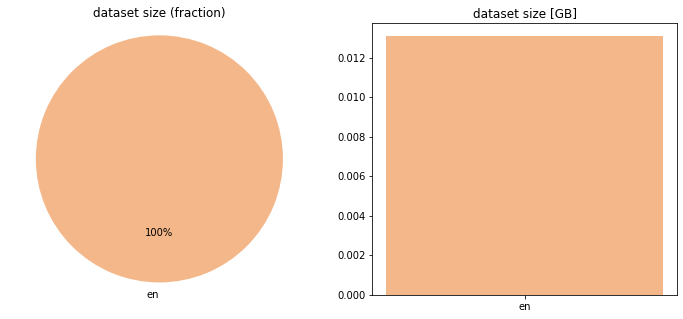

In [21]:
if len(ml):
    plot_overview_data(ml["models_pure"].values(), verbose=False)

### 3b. Evaluation #1: Vocabulary Intersection

In [22]:
vocabs = [10000, 20000, 30000, 40000, 51200, 64000]  # , 80000, 96000, 112000, 128000]
vocabs_1 = vocabs
vocabs_2 = vocabs

In [23]:
timelines = get_intersections(ml, vocabs_1, vocabs_2)

In [24]:
def plot_evaluation_1_fixed(_overlap_abs, _overlap_rel, _ymax):
    import matplotlib.pyplot as plt
    # colors = {"da": "r", "en": "g", "is": "b", "no": "purple", "sv": "orange"}
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    ax = [ax,]
    for l, language in enumerate(LANGUAGES):
        try:
            ax[0].bar(language, _overlap_abs[language], color=plots_color(language), label=language)
        except KeyError:
            ax[0].bar(language, 0, color=plots_color(language))
    ax[0].set_ylim([0, _ymax])
    # ax[0].legend()
        
    ax[0].set_title("vocabulary overlap")

In [25]:
@interact
def show_evaluation_1_fixed(tokenizer=ml['lang_all'], vocab_size=vocabs_2, absolute=[False, True]):
    if tokenizer is not None:
        lang_1 = tokenizer
        vocab_2 = vocab_size
        t_abs = timelines['abs'][lang_1][vocab_2]
        t_rel = timelines['rel'][lang_1][vocab_2]
        
        t_abs_last = {k: v[-1] for k, v in t_abs.items()}
        t_rel_last = {k: v[-1] for k, v in t_rel.items()}

        print(t_abs_last)
        print(t_rel_last)
        plot_evaluation_1_fixed(t_abs_last, t_rel_last, vocab_2)
    else:
        print("> lang_all is []")

interactive(children=(Dropdown(description='tokenizer', options=('all',), value='all'), Dropdown(description='…

In [26]:
@interact
def show_evaluation_1_varied(tokenizer=ml['lang_all'], vocab_size=vocabs_2, absolute=[True, False], languages_gptsw3=False):
    if tokenizer is not None:
        if languages_gptsw3:
            _languages = LANGUAGES
        else:
            _languages = ml['lang_pure']
        
        lang_1 = tokenizer
        vocab_2 = vocab_size
        t_abs = timelines['abs'][lang_1][vocab_2]
        t_rel = timelines['rel'][lang_1][vocab_2]
        
        t_abs = {language: t_abs[language] for language in _languages}  # order languages
        t_rel = {language: t_rel[language] for language in _languages}  # order languages

        if absolute:
            plot_timelines(
                vocabs_1,
                vocab_2,
                [t_rel, t_abs],
                _languages, 
                ylim=[1.1, 64000],
                ylabel=["", ""], 
                title=["vocabulary overlap"]*2,
            )
        else:
            plot_timelines(
                vocabs_1,
                vocab_2,
                [t_rel],
                _languages, 
                ylim=[1.1],
                ylabel=["relative"], 
                title=["vocabulary overlap"],
            )
    else:
        print("> lang_all is []")

interactive(children=(Dropdown(description='tokenizer', options=('all',), value='all'), Dropdown(description='…

### 3c. Evaluation #2: unk_rate & closeness_to_character_level

In [27]:
def plot_evaluation_2a(_unk_rate, _ctcl, _vocabs, _languages, _ymax):
    import matplotlib.pyplot as plt
    # colors = {"da": "r", "en": "g", "is": "b", "no": "purple", "sv": "orange"}
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    for language in LANGUAGES:
        try:
            ax[0].plot(_vocabs, _unk_rate[language], linestyle=None, marker="s", color=plots_color(language), label=language)
            ax[1].plot(_vocabs, _ctcl[language], linestyle=None, marker="s", color=plots_color(language), label=language)
        except KeyError:
            pass
    for i in range(2):
        ax[i].set_xlim([0, 150000])
        ax[i].set_ylim([_ymin, _ymax])
        ax[i].legend()
    ax[0].set_title("unknown rate (lower = better)")
    ax[1].set_title("closeness to character level (lower = better)")
    
def plot_evaluation_2b(_f, _p, _vocabs, _languages, _ymin, _ymax):
    import matplotlib.pyplot as plt
    # colors = {"da": "r", "en": "g", "is": "b", "no": "purple", "sv": "orange"}
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    for language in LANGUAGES:
        try:
            ax[0].plot(_vocabs, _f[language], linestyle=None, marker="s", color=plots_color(language), markerfacecolor="w", label=language)
            ax[1].plot(_vocabs, _p[language], linestyle=None, marker="s", color=plots_color(language), markerfacecolor="w", label=language)
        except KeyError:
            pass
    for i in range(2):
        # ax[i].set_xlim([0, 150000])
        ax[i].set_xlim([0, None])
    ax[1].legend()
        
    ax[0].set_ylim([1, _ymax])
    ax[1].set_ylim([0, 1])
    
    ax[0].set_title("fertility")
    ax[1].set_title("proportion of continued words")

In [28]:
@interact
def show_evaluation_2(result=get_list_of_results()):
    results = read_results(result)
    groups = retrieve_groups_from_results(results)
    
    @interact
    def show_evaluation_2_detail(group=groups, ymin=0.0, ymax=4.0):
        vocabs, vocabs_models, files, languages, languages_files = retrieve_parameters_from_results(group, results, verbose=False)
        
        unk_rate, ctcl, fertility, proportion = extract(results, vocabs_models, vocabs, languages_files, languages)

        # plot_evaluation_2a(unk_rate, ctcl, vocabs, languages, ymin, ymax)
        plot_evaluation_2b(fertility, proportion, vocabs, languages, ymin, ymax)

interactive(children=(Dropdown(description='result', options=('tokenizer1', 'tokenizer1_en'), value='tokenizer…